In [1]:
modified_kwave_path = R'C:\Users\pjh7\git\k-wave-python'
slicer_exe = R"C:\Users\pjh7\AppData\Local\NA-MIC\Slicer 5.2.2\Slicer.exe"
import sys
sys.path.append(modified_kwave_path)
import pyfus
from typing import List, Dict, Any, Tuple
import logging
root = logging.getLogger()
loglevel = logging.INFO
root.setLevel(loglevel)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(loglevel)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)
import numpy as np

In [2]:

arr = pyfus.Transducer.gen_matrix_array(nx=8, ny=8, pitch=4, kerf=.5, units="mm", impulse_response=1e5)
trans_matrix = np.array(
    [[-1,   0,  0, 0],
     [0, .05,  np.sqrt(1-.05**2), -105],
     [0, np.sqrt(1-.05**2),  -.05, 5],
     [0, 0,  0, 1]])
arr.rescale("mm")
arr.matrix = trans_matrix
pt = pyfus.Point(position=(5,-60,-8), units="mm", radius=2)

2024-04-12 23:31:14,237 - root - INFO - Initializing transducer array


In [3]:
pulse = pyfus.Pulse(frequency=400e3, duration=3/400e3)
sequence = pyfus.Sequence()
focal_pattern = pyfus.focal_patterns.Wheel(center=True, spoke_radius=5, num_spokes=5)
sim_setup = pyfus.SimSetup(dt=2e-7, t_end=100e-6)
protocol = pyfus.Protocol(
    pulse=pulse,
    sequence=sequence,
    focal_pattern=focal_pattern,
    sim_setup=sim_setup)
pts = protocol.focal_pattern.get_targets(pt)
coords = protocol.sim_setup.get_coords()
params = protocol.seg_method.ref_params(coords)
delays, apod = protocol.beamform(arr=arr, target=pts[0], params=params)


In [4]:
ds = pyfus.sim.run_simulation(arr=arr, 
        params=params, 
        delays=delays,
        apod= apod,
        freq = pulse.frequency,
        cycles = np.max([np.round(pulse.duration * pulse.frequency), 20]),
        dt=protocol.sim_setup.dt,
        t_end=protocol.sim_setup.t_end,
        amplitude = 1,
        save_gridweights=False)

2024-04-12 23:31:14,270 - root - INFO - Calculating grid weights
2024-04-12 23:31:14,954 - root - INFO - Getting binary mask
2024-04-12 23:31:15,350 - root - INFO - Getting distributed source signal
2024-04-12 23:31:15,756 - root - INFO - approximate size of source matrix: 2.33 G B ( float32 precision)
2024-04-12 23:31:15,794 - root - INFO - total computation time : 0.44 s
2024-04-12 23:31:15,795 - root - INFO - Running simulation
2024-04-12 23:31:15,796 - root - INFO - Starting Simulation Setup
2024-04-12 23:31:15,797 - root - INFO -   start time: 12-Apr-2024-23-31-15
2024-04-12 23:31:15,798 - root - INFO - Running k-Wave simulation...
2024-04-12 23:31:15,798 - root - INFO -   start time: 12-Apr-2024-23-31-15
2024-04-12 23:31:15,799 - root - INFO -   reference sound speed: 1500.0 m/s
2024-04-12 23:31:15,799 - root - INFO -   reference sound speed: 1500.0 m/s
2024-04-12 23:31:15,807 - root - INFO -   dt: 200ns, t_end: 99.8us, time steps: 500
2024-04-12 23:31:15,808 - root - INFO -   in

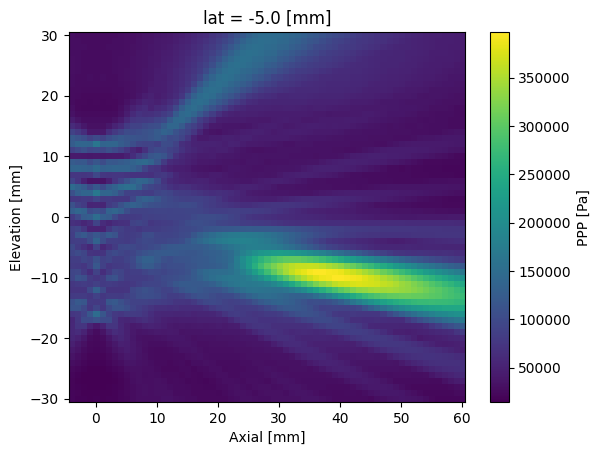

In [5]:
ds['p_max'].sel(lat=-5).plot.imshow()

In [6]:
# Export to .nii.gz
import nibabel as nb
output_filename = "foo.nii.gz"
trans_matrix = np.array(
    [[-1,   0,  0, 0],
     [0, .05,  np.sqrt(1-.05**2), -105],
     [0, np.sqrt(1-.05**2),  -.05, 5],
     [0, 0,  0, 1]])
da = ds['p_max'].interp({'lat':np.arange(-30, 30.1, 0.5),'ele':np.arange(-30, 30.1, 0.5), 'ax': np.arange(-4,70.1,0.5)})
origin_local = [float(val[0]) for dim, val in da.coords.items()]
dx = [float(val[1]-val[0]) for dim, val in da.coords.items()]
affine = np.array([-1,-1,1,1]).reshape(4,1)*np.concatenate([trans_matrix[:,:3], trans_matrix @ np.array(origin_local + [1]).reshape([4,1])], axis=1)*np.array(dx + [1]).reshape([1,4])
data = da.data
im = nb.Nifti1Image(data, affine)
h = im.header
h.set_xyzt_units('mm', 'sec')
im = nb.as_closest_canonical(im)
im.to_filename(output_filename)


In [7]:
# Load into Slicer
import slicerio.server
slicerio.server.file_load(output_filename, slicer_executable=slicer_exe)

['vtkMRMLScalarVolumeNode1']